In [33]:
import faiss
index = faiss.read_index("multi1MImageVectors.index")

In [34]:
import faiss
import numpy as np

def extract_vectors(index):
    d = index.d
    ntotal = index.ntotal
    vectors = np.zeros((ntotal, d), dtype=np.float32)
    for i in range(ntotal):
        vectors[i, :] = index.reconstruct(i)
    return vectors[:1000]
vectors = extract_vectors(index)

In [35]:
import numpy as np
from usearch.index import Index
key = np.arange(1000)
uIndex = Index(ndim=1152)

uIndex.add(key, vectors)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [36]:
uIndex.save("image1000Vectors.usearch")

<h1> Load USEARCH index <h1>

In [2]:
# !pip install usearch
from usearch.index import Index
uIndex = Index(ndim=1152)
loaded_copy = uIndex.load("image1000Vectors.usearch")

In [3]:
import torch
from transformers import AutoModel, AutoProcessor
from torchvision import transforms
from PIL import Image
import numpy as np
Imagemodel = AutoModel.from_pretrained("google/siglip-so400m-patch14-384", low_cpu_mem_usage=True)
processor = AutoProcessor.from_pretrained("google/siglip-so400m-patch14-384", low_cpu_mem_usage=True, do_rescale=False)
device_type = "cpu"
device = torch.device(device_type)
Imagemodel.to(device)
path = "static/images/person.jpeg"
newImage = Image.open(path)
transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
inputs = transform(newImage)
inputs = (inputs - inputs.min()) / (inputs.max() - inputs.min())
inputs = processor(images=inputs, return_tensors="pt").to(device)
features = Imagemodel.get_image_features(**inputs)
features = np.array(features.tolist())

In [4]:
def indices_to_images(indices):
    indices = [int(i) for i in indices]
    image_paths = []
    for i in indices:
        folder_name = i // 1000
        file_name = i % 1000
        folder_str = f"{folder_name:04d}"
        file_str = f"{file_name:03d}.jpg"
        image_paths.append("images" + "/" + folder_str + "/" + file_str)
    return image_paths
        
def ImageSimilar(features, k):
    matches = uIndex.search(features.flatten(), k)
    similarPath = indices_to_images(list(matches.keys))
    return similarPath

In [5]:
def get_true_positives(similar_paths, desired_label):
    total_occurences = 0
    for filepath in similar_paths:
        yolo_results_list = Yolomodel([filepath], verbose=False)
        for result in yolo_results_list[0]:
            img_label = result.names[int(result.boxes.cls[0])]
            #confidence_score = float(result.boxes.conf[0])
            if img_label == desired_label:
                total_occurences += 1
                break
    return total_occurences

In [6]:
import json
from ultralytics import YOLO
input_image_label = "person"
# Load the dictionary from the json file
with open('ground_truth.json', 'r') as f:
    ground_truth = json.load(f)
print(ground_truth[input_image_label])
similarPath = ImageSimilar(features, ground_truth[input_image_label])
Yolomodel = YOLO('yolov8x.pt')
total_positive_found = get_true_positives(similarPath, input_image_label)
print(total_positive_found)
accuracy = total_positive_found/ground_truth[input_image_label]
print(accuracy)

281
79
0.28113879003558717


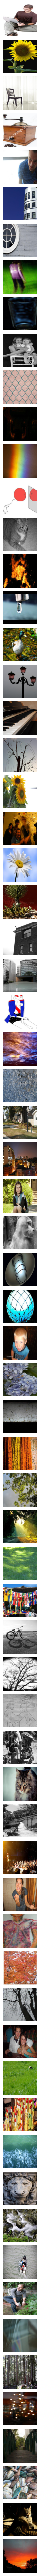

In [7]:
import matplotlib.pyplot as plt
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid
import requests
from io import BytesIO
res = []
fig = plt.figure(figsize=(100., 100.))
noRows = max(1, len(similarPath)//4)
grid = ImageGrid(fig,111,
                 nrows_ncols=(noRows, 100//noRows),
                 axes_pad=0.1,
                 )
for path in similarPath:
    url = "https://storage.googleapis.com/vislang-public/sbu-{}".format(path)
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img = img.resize((150, 150), resample=Image.BILINEAR)
    res.append(img)



for ax, im in zip(grid, res):
    ax.imshow(im)
    ax.axis('off')

_ = plt.show()